# Pre-Processing

In [37]:
# Import packages
import pandas as pd
import plotly.express as px
import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import display
import seaborn as sns

# Load the dataset
df = pd.read_csv('JISI4k - JISI4k.csv')

# Remove duplicates
duplicate_count = df.duplicated(keep=False).sum()
df = df.drop_duplicates()

# Create an assessment task column
df['assessment_task'] = df['assessmentname'] + ' ' + df['taskname']

# Pivot the DataFrame
df_pivoted = df.pivot_table(index=['studentid'], columns=['assessment_task'], values='score', aggfunc='first').reset_index()

metadata = df[['studentid', 'eslstatus', 'assessmentname', 'assessmentinstanceid', 'assessmentdate']].drop_duplicates('studentid')

df_pivoted = pd.merge(df_pivoted, metadata, on='studentid', how='left')

df_pivoted['eslstatus'] = df_pivoted['eslstatus'].replace({True: 1, False: 0})

# Count the number of missing (NaN) values in each row across all columns
missing_data_count = df_pivoted.isna().sum(axis=1)

# Find the minimum number of missing values
min_missing = missing_data_count.min()

# Create a new DataFrame with only students having the least missing data
df_least_missing = df_pivoted[missing_data_count == min_missing]
df_least_missing = df_least_missing.dropna(axis=1)


import numpy as np

# Check unique values in 'eslstatus' before filtering
print("Unique ESL status values:", df_least_missing['eslstatus'].unique())

# Create a complete dataset of both esl and nonesl for later analysis
df_total = df_least_missing.copy()

# Filter dataset to only include ESL students
df_least_missing_esl = df_least_missing[df_least_missing['eslstatus'] == 1].copy()

# Filter dataset to only include non-ESL students
df_least_missing_non_esl = df_least_missing[df_least_missing['eslstatus'] == 0].copy()

def create_progressrates(df):
    # Define test columns
    tests = [
        "Deletion", "Initial Phoneme", "Letter Name", "Letter Sound",
        "Phoneme Blending", "Rhyming", "Nonword Recognition", "Word Recognition"
    ]

    # Define assessment stages
    stages = ["Baseline", "Midpoint", "End of Year"]

    # Ensure relevant columns are numeric
    for col in df.columns:
        if any(stage in col for stage in stages):
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # Create progress rate columns
    progress_columns = []

    # Generate progress rate columns
    for test in tests:
        for level in ["Junior", "Senior"]:
            # Get columns for the test at different stages
            col_names = [
                f"{level} {stage} Screener {test}" for stage in stages if f"{level} {stage} Screener {test}" in df.columns
            ]

            # Ensure there are at least two columns to compute progress rate
            if len(col_names) >= 2:
                for i in range(len(col_names) - 1):
                    prev_col, next_col = col_names[i], col_names[i + 1]
                    progress_col = f"{prev_col} to {next_col} Progress Rate"

                    # Compute progress rate and handle division by zero
                    df[progress_col] = np.where(
                        df[prev_col] != 0,
                        (df[next_col] - df[prev_col]) / df[prev_col],
                        np.nan  # Set progress rate to NaN if division by zero
                    )

                    # Append to progress columns list
                    progress_columns.append(progress_col)

            # Manually add Junior End of Year to Senior Baseline progress rates
            if level == "Junior":
                junior_end_of_year_col = f"Junior End of Year Screener {test}"
                senior_baseline_col = f"Senior Baseline Screener {test}"

                if junior_end_of_year_col in df.columns and senior_baseline_col in df.columns:
                    progress_col = f"{junior_end_of_year_col} to {senior_baseline_col} Progress Rate"

                    # Compute progress rate and handle division by zero
                    df[progress_col] = np.where(
                        df[junior_end_of_year_col] != 0,
                        (df[senior_baseline_col] - df[junior_end_of_year_col]) / df[junior_end_of_year_col],
                        np.nan  # Set progress rate to NaN if division by zero
                    )

                    # Append to progress columns list
                    progress_columns.append(progress_col)

    # Handle division by zero or infinite values properly
    df.replace([float('inf'), -float('inf')], np.nan, inplace=True)

    # Explicitly convert progress columns to float
    if progress_columns:
        df[progress_columns] = df[progress_columns].astype(float)

    return df

# Apply progress rate calculations
df_least_missing_non_esl = create_progressrates(df_least_missing_non_esl)
df_least_missing_esl = create_progressrates(df_least_missing_esl)
df_total = create_progressrates(df_total)


from sklearn.preprocessing import StandardScaler
def scale(df):
    # Drop non-numeric columns before scaling
    columns_to_drop = {'studentid', 'assessmentname', 'assessmentinstanceid', 'assessmentdate', 'eslstatus'}
    df_copy = df.drop(columns=columns_to_drop.intersection(df.columns), errors='ignore').copy()

    # Separate numerical and non-numerical columns
    non_numeric_cols = df_copy.select_dtypes(exclude='number')
    task_scores = df_copy.select_dtypes(include='number')

    # Handle NaNs and inf values before scaling
    task_scores.replace([np.inf, -np.inf], np.nan, inplace=True)
    task_scores.fillna(task_scores.mean(), inplace=True)  # Fill NaNs with column mean

    # Subtract row mean
    row_means = task_scores.mean(axis=1)
    task_scores_centered = task_scores.sub(row_means, axis=0)

    # Normalize by column variance
    scaler = StandardScaler()
    task_scores_scaled = scaler.fit_transform(task_scores_centered)

    # Reconstruct DataFrame
    df_scaled = pd.DataFrame(task_scores_scaled, columns=task_scores.columns, index=df_copy.index)
    df_scaled = pd.concat([df_scaled, non_numeric_cols], axis=1)

    return df_scaled, scaler

def create_indices(df):
  # Create a copy of the DataFrame to avoid modifying the original
  full_df_labelled = df.copy()
  # Define the columns corresponding to each index
  phonemic_awareness_indices = [
      'Junior Baseline Screener Initial Phoneme',
      'Junior Midpoint Screener Initial Phoneme',
      'Junior End of Year Screener Initial Phoneme',
      'Senior Baseline Screener Initial Phoneme',
      'Junior Baseline Screener Phoneme Blending',
      'Junior Midpoint Screener Phoneme Blending',
  ]

  phoneme_manipulation_indices = [
      'Junior Baseline Screener Deletion',
      'Junior Midpoint Screener Deletion',
      'Junior End of Year Screener Deletion',
      'Senior Baseline Screener Deletion',
      'Junior Baseline Screener Rhyming'
  ]

  letter_sound_name_recognition_indices = [
      'Junior Baseline Screener Letter Name',
      'Junior Midpoint Screener Letter Name',
      'Junior Midpoint Screener Letter Sound',
      'Junior End of Year Screener Letter Sound',
      'Senior Baseline Screener Letter Sound'
  ]

  word_nonword_recognition_indices = [
      'Junior End of Year Screener Nonword Recognition',
      'Junior End of Year Screener Word Recognition',
      'Senior Baseline Screener Nonword Recognition',
      'Senior Baseline Screener Word Recognition'
  ]

  blending_rhyming_indices = [
        'Junior Baseline Screener Phoneme Blending',
        'Junior Midpoint Screener Phoneme Blending',
        'Junior Baseline Screener Rhyming'
    ]


  # Create columns for each of these indices by averaging the relevant columns
  full_df_labelled['Phonemic Awareness Index'] = full_df_labelled[phonemic_awareness_indices].mean(axis=1)
  full_df_labelled['Phoneme Manipulation Index'] = full_df_labelled[phoneme_manipulation_indices].mean(axis=1)
  full_df_labelled['Letter-Sound and Name Index'] = full_df_labelled[letter_sound_name_recognition_indices].mean(axis=1)
  full_df_labelled['Word and Nonword Recognition Index'] = full_df_labelled[word_nonword_recognition_indices].mean(axis=1)
  full_df_labelled['Blending and Rhyming Index'] = full_df_labelled[blending_rhyming_indices].mean(axis=1)


  return full_df_labelled

# Lets do the same but only using junior infants
def create_indices_junior(df):
  # Create a copy of the DataFrame to avoid modifying the original
  full_df_labelled = df.copy()
  # Define the columns corresponding to each index
  phonemic_awareness_indices = [
      'Junior Baseline Screener Initial Phoneme',
      'Junior Midpoint Screener Initial Phoneme',
      'Junior End of Year Screener Initial Phoneme',
      'Junior Baseline Screener Phoneme Blending',
      'Junior Midpoint Screener Phoneme Blending',
  ]

  phoneme_manipulation_indices = [
      'Junior Baseline Screener Deletion',
      'Junior Midpoint Screener Deletion',
      'Junior End of Year Screener Deletion',
      'Junior Baseline Screener Rhyming'
  ]

  letter_sound_name_recognition_indices = [
      'Junior Baseline Screener Letter Name',
      'Junior Midpoint Screener Letter Name',
      'Junior Midpoint Screener Letter Sound',
      'Junior End of Year Screener Letter Sound' ]

  word_nonword_recognition_indices = [
      'Junior End of Year Screener Nonword Recognition',
      'Junior End of Year Screener Word Recognition'
  ]

  blending_rhyming_indices = [
      'Junior Baseline Screener Phoneme Blending',
      'Junior Midpoint Screener Phoneme Blending',
      'Junior Baseline Screener Rhyming'
  ]


  # Create columns for each of these indices by averaging the relevant columns
  full_df_labelled['Phonemic Awareness Index'] = full_df_labelled[phonemic_awareness_indices].mean(axis=1)
  full_df_labelled['Phoneme Manipulation Index'] = full_df_labelled[phoneme_manipulation_indices].mean(axis=1)
  full_df_labelled['Letter-Sound and Name Index'] = full_df_labelled[letter_sound_name_recognition_indices].mean(axis=1)
  full_df_labelled['Word and Nonword Recognition Index'] = full_df_labelled[word_nonword_recognition_indices].mean(axis=1)
  full_df_labelled['Blending and Rhyming Index'] = full_df_labelled[blending_rhyming_indices].mean(axis=1)


  return full_df_labelled

# Scale the df of non esl students
df_least_missing_scaled, scaler_least_missing = scale(df_least_missing_non_esl)
df_indices_non_esl = create_indices(df_least_missing_scaled)

df_junior_indices = create_indices_junior(df_total)


# Create indices for esl and scale
df_least_missing_esl_scaled, scaler_least_missing_esl = scale(df_least_missing_esl)
df_indices_esl = create_indices(df_least_missing_esl_scaled)

# Scale and create indices for the full data
df_total_scaled, scaler_total = scale(df_total)
df_indices_total = create_indices(df_total_scaled)



<ipython-input-37-b36ae2bdf33a>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['assessment_task'] = df['assessmentname'] + ' ' + df['taskname']
<ipython-input-37-b36ae2bdf33a>:26: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_pivoted['eslstatus'] = df_pivoted['eslstatus'].replace({True: 1, False: 0})


Unique ESL status values: [0 1]


In [38]:
from IPython.display import display

df_least_missing

studentid  \
223    01a1b820-82f8-11ee-bacd-5dc402067e02   
224    01a20640-82f8-11ee-bacd-5dc402067e02   
225    01a27b70-82f8-11ee-bacd-5dc402067e02   
226    01a317b0-82f8-11ee-bacd-5dc402067e02   
227    01a365d0-82f8-11ee-bacd-5dc402067e02   
...                                     ...   
35201  ff492a70-57bb-11ee-b034-41a216ee479c   
35202  ff495180-57bb-11ee-b034-41a216ee479c   
35203  ff495181-57bb-11ee-b034-41a216ee479c   
35204  ff497890-57bb-11ee-b034-41a216ee479c   
35205  ff499fa0-57bb-11ee-b034-41a216ee479c   

       Junior Baseline Screener Deletion  \
223                                  0.9   
224                                  0.5   
225                                  0.9   
226                                  0.8   
227                                  0.9   
...                                  ...   
35201                                0.9   
35202                                0.4   
35203                                0.5   
35204                                0.3   
35205                                0.6   

       Junior Baseline Screener Initial Phoneme  \
223                                    0.636364   
224                                    0.454545   
225                                    0.636364   
226                                    0.636364   
227                                    0.454545   
...                                         ...   
35201                                  0.909091   
35202                                  0.636364   
35203                                  0.636364   
35204                                  0.363636   
35205                                  0.181818   

       Junior Baseline Screener Letter Name  \
223                                0.307692   
224                                0.346154   
225                                0.230769   
226                                0.769231   
227                                0.192308   
...                                     ...   
35201                              0.923077   
35202                              0.807692   
35203                              0.769231   
35204                              0.153846   
35205                              0.423077   

       Junior Baseline Screener Phoneme Blending  \
223                                     0.000000   
224                                     0.454545   
225                                     0.909091   
226                                     0.545455   
227                                     0.909091   
...                                          ...   
35201                                   1.000000   
35202                                   0.727273   
35203                                   1.000000   
35204                                   0.363636   
35205                                   0.909091   

       Junior Baseline Screener Rhyming  Junior End of Year Screener Deletion  \
223                                 0.8                                   1.0   
224                                 0.7                                   0.9   
225                                 0.8                                   0.8   
226                                 0.6                                   1.0   
227                                 0.8                                   1.0   
...                                 ...                                   ...   
35201                               0.8                                   0.9   
35202                               1.0                                   1.0   
35203                               1.0                                   1.0   
35204                               1.0                                   0.7   
35205                               0.6                                   0.9   

       Junior End of Year Screener Initial Phoneme  \
223                                       1.000000   
224                                       0.727273   
22

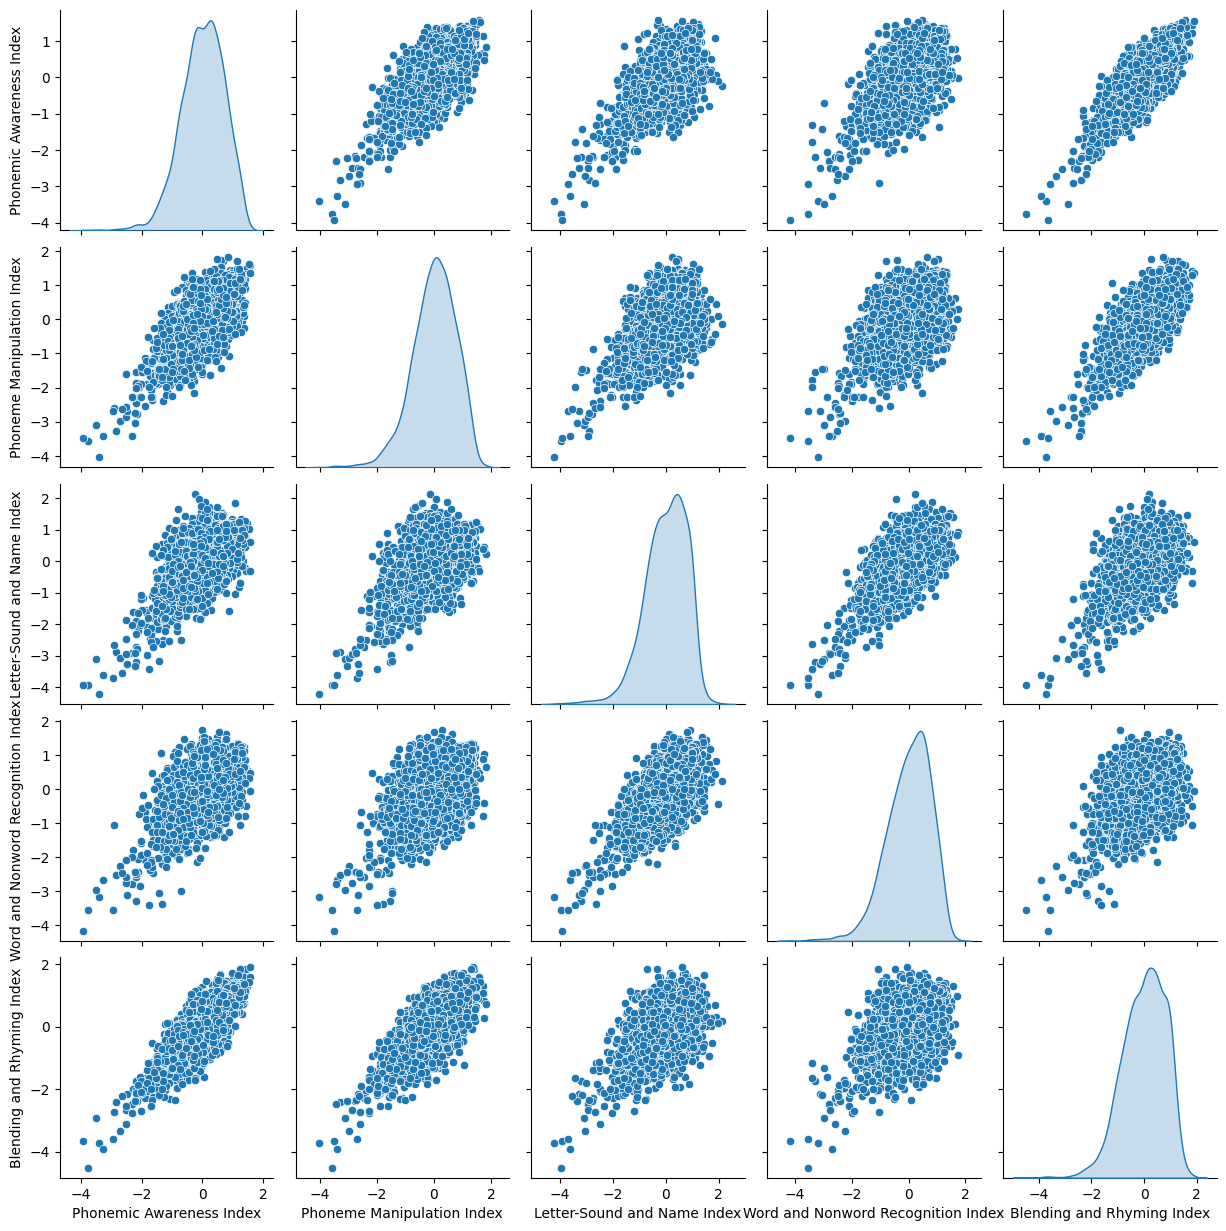

In [39]:
sns.pairplot(df_indices_total[['Phonemic Awareness Index', 'Phoneme Manipulation Index', 'Letter-Sound and Name Index', 'Word and Nonword Recognition Index', 'Blending and Rhyming Index']], diag_kind='kde')
plt.savefig('pairplot.svg')

In [40]:
df_least_missing_esl_scaled

Junior Baseline Screener Deletion  \
239                            -0.902136   
683                             0.869858   
684                             0.086031   
690                             0.356035   
696                            -0.756192   
...                                  ...   
34366                           1.633572   
34371                           0.295435   
34573                          -0.825372   
34577                           0.008487   
34581                          -0.556697   

       Junior Baseline Screener Initial Phoneme  \
239                                   -1.011959   
683                                    1.888819   
684                                    0.894216   
690                                    1.113808   
696                                   -0.416999   
...                                         ...   
34366                                  1.030381   
34371                                 -0.515037   
34573                                  0.173431   
34577                                 -0.128133   
34581                                 -0.689111   

       Junior Baseline Screener Letter Name  \
239                               -1.667012   
683                                0.375988   
684                               -0.154045   
690                                1.431097   
696                               -0.190395   
...                                     ...   
34366                              0.680895   
34371                             -0.411864   
34573                             -0.250913   
34577                             -0.662882   
34581                             -1.494534   

       Junior Baseline Screener Phoneme Blending  \
239                                    -1.526452   
683                                     1.456505   
684                                     1.445441   
690                                     0.437749   
696                                    -0.068765   
...                                          ...   
34366                                   0.965961   
34371                                  -0.159351   
34573                                   0.174142   
34577                                  -0.709799   
34581                                   0.890400   

       Junior Baseline Screener Rhyming  Junior End of Year Screener Deletion  \
239                           -1.268505                             -0.830125   
683                            1.811819                              1.467404   
684                            0.724945                              1.864290   
690                            0.617585                              1.330760   
696                            1.375403                              1.788461   
...                                 ...                                   ...   
34366                          0.013420                             -0.182486   
34371                          0.202936                              0.445170   
34573                          0.236135                             -0.748379   
34577                         -0.063776                             -1.091986   
34581                         -0.589104                             -0.462267   

       Junior End of Year Screener Initial Phoneme  \
239                                      -1.017553   
683                                       1.678634   
684                                       0.636507   
690                                       1.209785   
696                                       0.292222   
...                                            ...   
34366                                    -0.593595   
34371                                    -0.840081   
34573                                    -0.118717   
34577                                    -0.777884   
34581                                    -0.336085   

       Junior End of Year Screener Letter Sound  \
23

# Cluster Assignment

In [41]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

def test_clustering(X, cluster_labels, clusteringname):

    n_clusters_ = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    if n_clusters_ < 2:
        print("Warning: Less than 2 clusters found. Silhouette Score cannot be calculated.")
        # Handle the case with 0 clusters or all noise points
        # Option 1: Return NaN values for the metrics
        return {
            "Silhouette Score": float('nan'),
            "Davies-Bouldin Index": float('nan'),
            "Calinski-Harabasz Index": float('nan'),
        }

    # Step 1: Calculate Silhouette Score
    sil_score = silhouette_score(X, cluster_labels)

    # Step 2: Calculate Davies-Bouldin Index
    db_index = davies_bouldin_score(X, cluster_labels)

    # Step 3: Calculate Calinski-Harabasz Index
    ch_score = calinski_harabasz_score(X, cluster_labels)

    # Return the scores as a dictionary
    return {
        "Silhouette Score": sil_score,
        "Davies-Bouldin Index": db_index,
        "Calinski-Harabasz Index": ch_score,
    }

In [42]:
# Function to flag students in the bottom percentile for both phonemic indices
def flag_at_risk_students(df, percentile_threshold=25, phonemic_columns = ['Phonemic Awareness Index', 'Phoneme Manipulation Index']):
    # Compute percentile cutoffs for each column
    cutoffs = {col: np.percentile(df[col], percentile_threshold) for col in phonemic_columns}

    # Flag students below the threshold in both columns
    df["Cluster"] = ((df[phonemic_columns[0]] < cutoffs[phonemic_columns[0]]) &
                      (df[phonemic_columns[1]] < cutoffs[phonemic_columns[1]])).astype(int)
    return df

# Apply the function to the data
df_indices_flagged = flag_at_risk_students(df_indices_non_esl)
df_indices_flagged_esl = flag_at_risk_students(df_indices_esl, percentile_threshold=25)

def remerge_data(input_df, labelled_data, output_df):
    # Add labels to the original DataFrame
    df_with_labels = input_df.copy()
    df_with_labels["Cluster"] = labelled_data['Cluster']
    df_with_labels['Phonemic Awareness Index'] = labelled_data['Phonemic Awareness Index']
    df_with_labels['Phoneme Manipulation Index'] = labelled_data['Phoneme Manipulation Index']
    df_with_labels['Letter-Sound and Name Index'] = labelled_data['Letter-Sound and Name Index']
    df_with_labels['Word and Nonword Recognition Index'] = labelled_data['Word and Nonword Recognition Index']
    df_with_labels['Blending and Rhyming Index'] = labelled_data['Blending and Rhyming Index']

    return df_with_labels

df_full = remerge_data(df_least_missing_non_esl, df_indices_non_esl, 'df_with_labels.csv')

df_full_esl = remerge_data(df_least_missing_esl, df_indices_esl, 'df_with_labels_esl.csv')

iqr_data = pd.concat([df_full.reset_index(drop=True), df_full_esl.reset_index(drop=True)])

In [43]:
import umap
from mpl_toolkits.mplot3d import Axes3D  # Import for 3D plotting
import plotly.graph_objects as go

def custom_umap(df, n_components=2, random_state=42, n_neighbors=15, min_dist=0.1, metric='euclidean'):
    """
    Perform UMAP on the dataset to reduce dimensions and visualize results in 2D and 3D.

    Parameters:
    - df: DataFrame containing the data to be reduced
    - n_components: Number of components to reduce to (default 2 for 2D, or 3 for 3D)
    - random_state: Seed for reproducibility
    - n_neighbors: Number of neighbors for UMAP (default 15)
    - min_dist: Minimum distance between points in the UMAP (default 0.1)

    Returns:
    - embedding: Reduced data (2D or 3D)
    """
    # Scale the data
    data_scaled = df

    # Perform UMAP
    reducer = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist, random_state=random_state)
    embedding = reducer.fit_transform(data_scaled)

    # Create a DataFrame for easy plotting
    umap_df = pd.DataFrame(embedding, columns=[f'UMAP{i+1}' for i in range(n_components)])

    return embedding

umap_data_total= custom_umap(df_indices_non_esl, n_components=2, random_state=42, n_neighbors=15, min_dist=0.01, metric='euclidean')

from sklearn.cluster import DBSCAN
def perform_dbscan(X, is_pca, eps=0.6, min_samples=75):
    # Apply DBSCAN
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    labels = db.labels_

    # Number of clusters and noise points
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print(f"Estimated number of clusters: {n_clusters_}")
    print(f"Estimated number of noise points: {n_noise_}")

    return labels


def predict_on_data(umap_data, eps=0.6, min_samples=75):
    # Perform DBSCAN clustering
    dbscan_labels = perform_dbscan(umap_data, eps=eps, min_samples=min_samples, is_pca=False)

    # Add labels to the DataFrame
    df_with_labels = pd.DataFrame(umap_data, columns=["UMAP1", "UMAP2"])
    df_with_labels["Cluster"] = dbscan_labels

    # Test clustering results
    clustering_scores = test_clustering(umap_data, dbscan_labels, clusteringname="DBSCAN (UMAP-Based)")

    return df_with_labels, clustering_scores

# Example call to predict and visualize clustering results
dbscan_data, dbscan_scores = predict_on_data(umap_data_total)



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Estimated number of clusters: 4
Estimated number of noise points: 115


In [44]:
# Get the number of students available in dbscan_data (or change to umap_df if needed)
num_umap_students = len(dbscan_data)  # Assuming dbscan_data contains the first set of clusters

# Reset indices to prevent misalignment
dbscan_data_labelled_full = df_total_scaled.reset_index(drop=True).copy()
dbscan_data = dbscan_data.reset_index(drop=True)
df_full_esl = df_full_esl.reset_index(drop=True)

# Step 1: Assign Cluster values from dbscan_data to the first N students
dbscan_data_labelled_full.loc[:num_umap_students - 1, "Cluster"] = dbscan_data["Cluster"].values

# Step 2: Assign Cluster values from df_full_esl to the remaining students
dbscan_data_labelled_full.loc[num_umap_students:, "Cluster"] = df_full_esl["Cluster"].values

# Verify the final distribution
print(dbscan_data_labelled_full["Cluster"].value_counts())


Cluster
 0.0    2455
 2.0     151
 1.0     126
-1.0     115
 3.0      80
Name: count, dtype: int64


In [45]:
# Reset index of original_df to ensure alignment
df_total = df_total.reset_index(drop=True)

# Add the cluster labels to the original DataFrame
#dbscan_data_labelled = df_least_missing_non_esl.copy()
#dbscan_data_labelled['Cluster'] = dbscan_data['Cluster']
#dbscan_data_labelled_full = pd.concat([dbscan_data_labelled, df_full_esl.reset_index(drop=True)])

df_with_labels = iqr_data.copy()
df_with_labels.rename(columns={'Cluster': 'Cluster_iqr'}, inplace=True)
df_with_labels['Cluster_dbscan'] = dbscan_data_labelled_full.reset_index(drop=True)['Cluster']
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
columns_to_normalize = [
    'Phonemic Awareness Index',
    'Phoneme Manipulation Index',
    'Letter-Sound and Name Index',
    'Word and Nonword Recognition Index',
    'Blending and Rhyming Index'
]

df_with_labels[columns_to_normalize] = scaler.fit_transform(df_with_labels[columns_to_normalize])

In [46]:
df_with_labels['Cluster_dbscan'].value_counts()

Cluster_dbscan
 0.0    2452
 2.0     167
-1.0     125
 1.0      93
 3.0      90
Name: count, dtype: int64

In [47]:
df_with_labels.columns

Index(['studentid', 'Junior Baseline Screener Deletion',
       'Junior Baseline Screener Initial Phoneme',
       'Junior Baseline Screener Letter Name',
       'Junior Baseline Screener Phoneme Blending',
       'Junior Baseline Screener Rhyming',
       'Junior End of Year Screener Deletion',
       'Junior End of Year Screener Initial Phoneme',
       'Junior End of Year Screener Letter Sound',
       'Junior End of Year Screener Nonword Recognition',
       'Junior End of Year Screener Word Recognition',
       'Junior Midpoint Screener Deletion',
       'Junior Midpoint Screener Initial Phoneme',
       'Junior Midpoint Screener Letter Name',
       'Junior Midpoint Screener Letter Sound',
       'Junior Midpoint Screener Phoneme Blending',
       'Senior Baseline Screener Deletion',
       'Senior Baseline Screener Initial Phoneme',
       'Senior Baseline Screener Letter Sound',
       'Senior Baseline Screener Nonword Recognition',
       'Senior Baseline Screener Word Recogni

# Statistical T-Test


In [48]:
df_with_labels_indices = df_with_labels[['Phonemic Awareness Index', 'Phoneme Manipulation Index', 'Letter-Sound and Name Index', 'Word and Nonword Recognition Index', 'Blending and Rhyming Index', 'Cluster_iqr', 'Cluster_dbscan']]

In [49]:
# Perform Levene's test and welchs t test on the cluster_iqr column
from scipy.stats import levene, ttest_ind

# Select only the index columns and Cluster_iqr
df_with_labels_indices = df_with_labels[['Phonemic Awareness Index',
                                         'Phoneme Manipulation Index',
                                         'Letter-Sound and Name Index',
                                         'Word and Nonword Recognition Index',
                                         'Blending and Rhyming Index',
                                         'Cluster_iqr', 'Cluster_dbscan']]


def levenes_test(df, cluster_col, num_cols, alpha=0.05):
    """
    Perform Levene's Test for equal variances across clusters for each numerical feature.

    Parameters:
        df (pd.DataFrame): Dataframe containing the data.
        cluster_col (str): Column name of the cluster labels.
        num_cols (list): List of numerical column names to test.
        alpha (float): Significance level (default=0.05).

    Returns:
        pd.DataFrame: Results of Levene's test for each numerical feature.
    """
    clusters = df[cluster_col].unique()
    if len(clusters) < 2:
        raise ValueError(f"Expected at least two clusters in {cluster_col}, but found {clusters}")

    results = []

    for feature in num_cols:
        # Extract values for each cluster
        groups = [df[df[cluster_col] == c][feature].dropna() for c in clusters]

        # Skip if any group is empty
        if any(len(g) == 0 for g in groups):
            continue

        # Levene’s test for equal variances
        stat_levene, p_levene = levene(*groups)

        # Interpretation
        variance_result = "Equal variances" if p_levene > alpha else "Unequal variances"

        # Store results
        results.append({
            'Feature': feature,
            'Levene Test Statistic': stat_levene,
            'Levene p-value': p_levene,
            'Variance': variance_result
        })

    return pd.DataFrame(results)

# Using for IQR results
df_levene_results = levenes_test(df_with_labels_indices, 'Cluster_iqr', df_with_labels_indices.columns)
print(df_levene_results)

# Using for DBScan results
df_levene_results_db = levenes_test(df_with_labels_indices, 'Cluster_dbscan', df_with_labels_indices.columns)
print(df_levene_results_db)

                              Feature  Levene Test Statistic  Levene p-value  \
0            Phonemic Awareness Index              16.432807    5.171945e-05   
1          Phoneme Manipulation Index               3.177734    7.475188e-02   
2         Letter-Sound and Name Index              45.764306    1.604514e-11   
3  Word and Nonword Recognition Index              31.225362    2.508758e-08   
4          Blending and Rhyming Index               5.603657    1.798778e-02   
5                         Cluster_iqr                    NaN             NaN   
6                      Cluster_dbscan             366.283994    5.089635e-77   

            Variance  
0  Unequal variances  
1    Equal variances  
2  Unequal variances  
3  Unequal variances  
4  Unequal variances  
5  Unequal variances  
6  Unequal variances  
                              Feature  Levene Test Statistic  Levene p-value  \
0            Phonemic Awareness Index              11.628171    2.278738e-09   
1          Phon

/usr/local/lib/python3.11/dist-packages/scipy/stats/_morestats.py:3361: RuntimeWarning: invalid value encountered in scalar divide
  W = numer / denom
/usr/local/lib/python3.11/dist-packages/scipy/stats/_morestats.py:3361: RuntimeWarning: invalid value encountered in scalar divide
  W = numer / denom


In [50]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind

def perform_t_test(df, cluster_col, alpha=0.05, equal_var=True):
    """
    Perform Welch's T-Test for each numerical feature based on cluster labels.

    Parameters:
        df (pd.DataFrame): DataFrame containing the data.
        cluster_col (str): Column name of the cluster labels (should be binary: 0 and 1).
        alpha (float): Significance level for the tests (default is 0.05).

    Returns:
        pd.DataFrame: Results of the Welch's T-Test for each numerical feature.
    """
    # Get numerical columns (excluding the cluster column)
    num_cols = df.select_dtypes(include=[np.number]).columns
    num_cols = [col for col in num_cols if col != cluster_col]

    # Ensure the cluster column is binary (0 and 1)
    clusters = df[cluster_col].unique()
    if len(clusters) != 2:
        raise ValueError(f"Expected exactly 2 clusters, but found {len(clusters)} unique clusters.")

    group_0 = df[df[cluster_col] == clusters[0]]
    group_1 = df[df[cluster_col] == clusters[1]]

    results = []

    for feature in num_cols:
        # Extract values for the feature from both groups
        values_0 = group_0[feature].dropna()
        values_1 = group_1[feature].dropna()

        # Skip if either group is empty
        if len(values_0) == 0 or len(values_1) == 0:
            continue

        # Welch's T-Test (without equal variance assumption)
        t_stat, p_ttest = ttest_ind(values_0, values_1, equal_var=equal_var)

        # Interpret results based on p-value
        significance_result = "Significant difference" if p_ttest < alpha else "No significant difference"

        # Store results
        results.append({
            'Feature': feature,
            'T-test Statistic': t_stat,
            'T-test p-value': p_ttest,
            'Difference': significance_result
        })

    return pd.DataFrame(results)

# Run Welch’s t-test only for PMI
df_results_pmi = perform_t_test(df_with_labels_indices[['Phoneme Manipulation Index', 'Cluster_iqr']], 'Cluster_iqr', equal_var=False)

# Run Student’s t-test for all other indices
df_results_other = perform_t_test(df_with_labels_indices.drop(columns=['Phoneme Manipulation Index']), 'Cluster_iqr', equal_var=True)

# Combine results into one DataFrame
df_results = pd.concat([df_results_pmi, df_results_other])

# Print the final results
print(df_results)



                              Feature  T-test Statistic  T-test p-value  \
0          Phoneme Manipulation Index         43.319220   6.126464e-187   
0            Phonemic Awareness Index         44.616362    0.000000e+00   
1         Letter-Sound and Name Index         31.643115   2.988901e-189   
2  Word and Nonword Recognition Index         29.748670   3.930275e-170   
3          Blending and Rhyming Index         39.364038   2.455631e-272   
4                      Cluster_dbscan         -9.200526    6.588953e-20   

               Difference  
0  Significant difference  
0  Significant difference  
1  Significant difference  
2  Significant difference  
3  Significant difference  
4  Significant difference  


In [51]:
import pandas as pd
import numpy as np
from statsmodels.multivariate.manova import MANOVA

def manova(df, clustercolumn):
    # Define the original column names
    original_indices = [
        'Phonemic Awareness Index', 'Phoneme Manipulation Index',
        'Letter-Sound and Name Index', 'Word and Nonword Recognition Index',
        'Blending and Rhyming Index'
    ]

    # Create a dictionary to rename columns (remove spaces and hyphens)
    renamed_indices = {col: col.replace(" ", "_").replace("-", "_") for col in original_indices}

    # Copy the dataframe and rename columns
    df_manova = df.copy()

    # Ensure cluster column exists
    if clustercolumn not in df_manova.columns:
        raise ValueError(f"Error: '{clustercolumn}' column not found in the dataset.")

    # Rename columns
    df_manova = df_manova.rename(columns=renamed_indices)

    # Ensure 'clustercolumn' is categorical
    df_manova[clustercolumn] = df_manova[clustercolumn].astype('category')

    # Extract new column names after renaming
    new_indices = list(renamed_indices.values())

    # Ensure dependent variables are numeric
    df_manova[new_indices] = df_manova[new_indices].apply(pd.to_numeric, errors='coerce')

    # Drop rows with missing values in dependent variables
    df_manova = df_manova.dropna(subset=new_indices)

    # Check if there are at least two clusters
    if df_manova[clustercolumn].nunique() < 2:
        raise ValueError(f"Error: '{clustercolumn}' must have at least two unique values for MANOVA.")

    # Build and fit the MANOVA model
    formula = f"{' + '.join(new_indices)} ~ {clustercolumn}"
    try:
        manova_model = MANOVA.from_formula(formula, data=df_manova)
        print(manova_model.mv_test())
    except Exception as e:
        print(f"Error in MANOVA: {e}")

# Call function with correct parameters
manova(df_with_labels_indices, 'Cluster_dbscan')


                    Multivariate linear model
                                                                 
-----------------------------------------------------------------
         Intercept        Value  Num DF   Den DF  F Value  Pr > F
-----------------------------------------------------------------
            Wilks' lambda 0.4364 5.0000 2918.0000 753.8507 0.0000
           Pillai's trace 0.5636 5.0000 2918.0000 753.8507 0.0000
   Hotelling-Lawley trace 1.2917 5.0000 2918.0000 753.8507 0.0000
      Roy's greatest root 1.2917 5.0000 2918.0000 753.8507 0.0000
-----------------------------------------------------------------
                                                                 
-----------------------------------------------------------------
     Cluster_dbscan     Value   Num DF   Den DF   F Value  Pr > F
-----------------------------------------------------------------
          Wilks' lambda 0.7184 20.0000  9678.8610  50.7363 0.0000
         Pillai's trace 0.2865

In [52]:
# No significant differences with 4 clusters, so relabel and try t test
df_with_labels_indices_relabelled = df_with_labels_indices.copy()
df_with_labels_indices_relabelled['Cluster_dbscan'] = df_with_labels_indices_relabelled['Cluster_dbscan'].replace({-1: 1, 2: 1, 3:1})

df_with_labels_relabelled = df_with_labels.copy()
df_with_labels_relabelled['Cluster_dbscan'] = df_with_labels_relabelled['Cluster_dbscan'].replace({-1: 1, 2: 1, 3:1})

# Using for DBScan results
df_levene_results_db = levenes_test(df_with_labels_indices_relabelled, 'Cluster_dbscan', df_with_labels_indices_relabelled.columns)
print(df_levene_results_db)

df_results_dbscan = perform_t_test(df_with_labels_indices_relabelled, 'Cluster_dbscan', equal_var=True)
print(df_results_dbscan)



                              Feature  Levene Test Statistic  Levene p-value  \
0            Phonemic Awareness Index               2.182758    1.396718e-01   
1          Phoneme Manipulation Index               0.067515    7.950076e-01   
2         Letter-Sound and Name Index               6.606058    1.021231e-02   
3  Word and Nonword Recognition Index               0.223678    6.362868e-01   
4          Blending and Rhyming Index               0.889258    3.457563e-01   
5                         Cluster_iqr             642.196267   2.960310e-128   
6                      Cluster_dbscan                    NaN             NaN   

            Variance  
0    Equal variances  
1    Equal variances  
2  Unequal variances  
3    Equal variances  
4    Equal variances  
5  Unequal variances  
6  Unequal variances  
                              Feature  T-test Statistic  T-test p-value  \
0            Phonemic Awareness Index         27.272647   4.054540e-146   
1          Phoneme Manipu

/usr/local/lib/python3.11/dist-packages/scipy/stats/_morestats.py:3361: RuntimeWarning: invalid value encountered in scalar divide
  W = numer / denom


In [53]:
df_with_labels_indices_relabelled

Phonemic Awareness Index  Phoneme Manipulation Index  \
0                    0.654409                    0.868086   
1                    0.760306                    0.716020   
2                    0.591183                    0.723511   
3                    0.834162                    0.824952   
4                    0.781448                    0.884615   
..                        ...                         ...   
300                  0.777195                    0.780972   
301                  0.592823                    0.735454   
302                  0.708455                    0.648907   
303                  0.621071                    0.644437   
304                  0.721412                    0.615663   

     Letter-Sound and Name Index  Word and Nonword Recognition Index  \
0                       0.626379                            0.871149   
1                       0.725155                            0.825954   
2                       0.493303                            0.785123   
3                       0.755618                            0.793754   
4                       0.642457                            0.726648   
..                           ...                                 ...   
300                     0.593998                            0.619036   
301                     0.634791                            0.485153   
302                     0.586492                            0.713019   
303                     0.626997                            0.603535   
304                     0.517978                            0.613660   

     Blending and Rhyming Index  Cluster_iqr  Cluster_dbscan  
0                      0.460672            0             0.0  
1                      0.650835            0             0.0  
2                      0.507983            0             1.0  
3                      0.711519            0             0.0  
4                      0.811064            0             0.0  
..                          ...          ...             ...  
300                    0.764293            0             0.0  
301                    0.649892            0             0.0  
302                    0.654860            0             0.0  
303                    0.624941            0             0.0  
304                    0.638146            0             1.0  

[2927 rows x 7 columns]

In [54]:
test_clustering(df_with_labels_indices_relabelled.drop(columns=['Cluster_dbscan']), df_with_labels_relabelled['Cluster_dbscan'].dropna(), 'DBSCAN')
#test_clustering(df_with_labels_indices_relabelled.drop(columns=['Cluster_iqr']), df_with_labels_relabelled['Cluster_iqr'].dropna(), 'IQR')


{'Silhouette Score': np.float64(0.3656752615585193),
 'Davies-Bouldin Index': np.float64(1.6396600340445449),
 'Calinski-Harabasz Index': np.float64(635.057739169862)}

# Comparing the dataframes

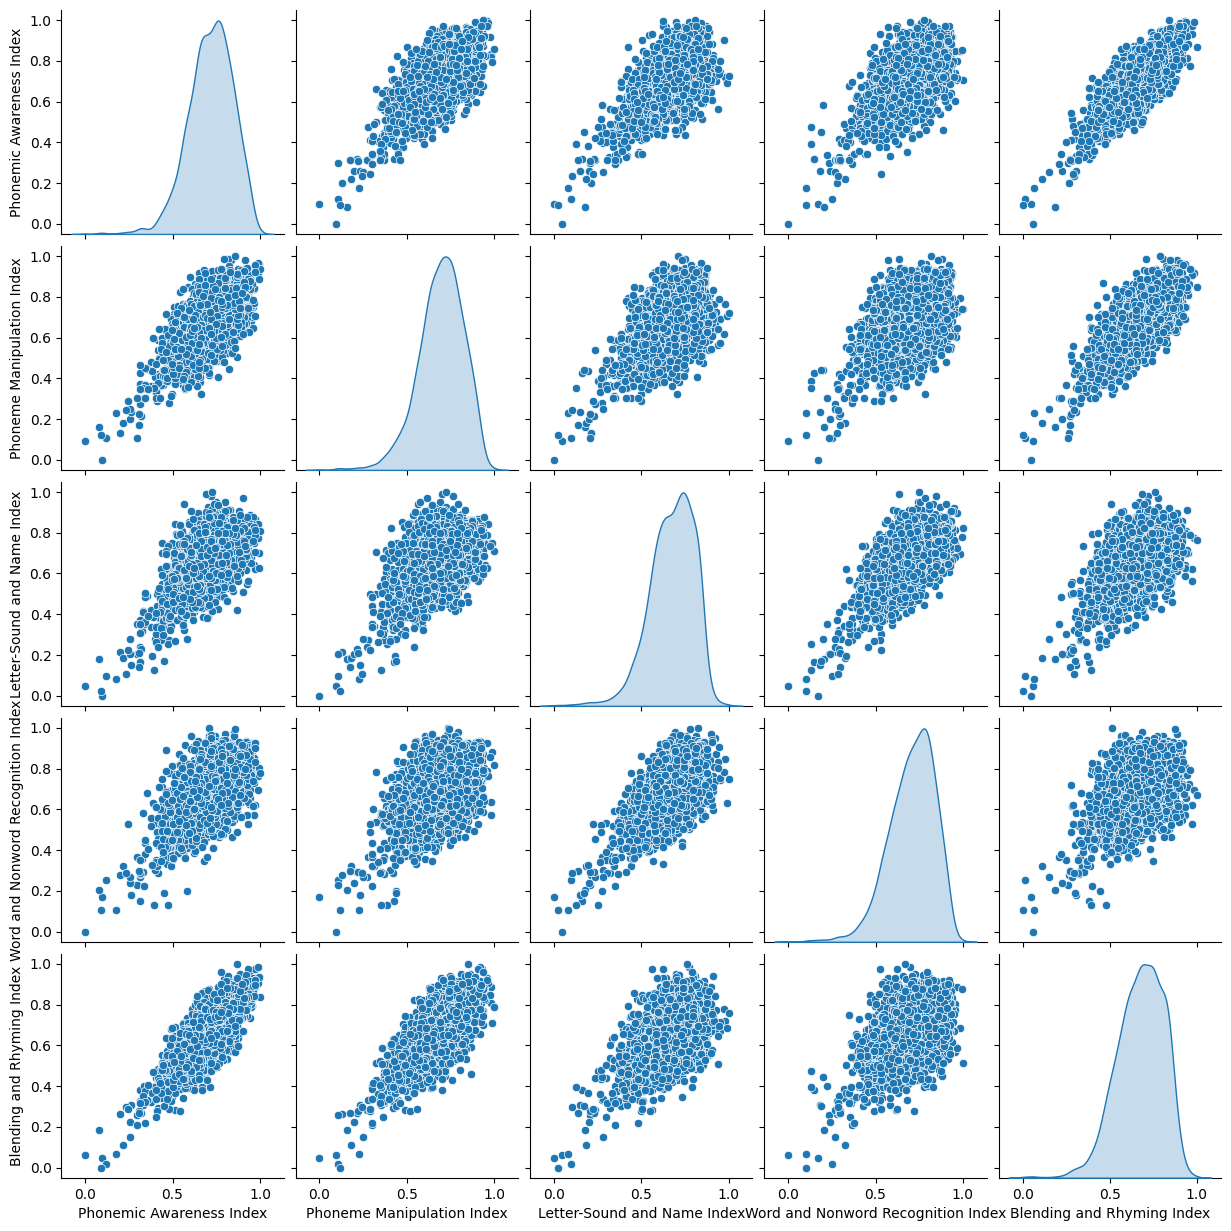

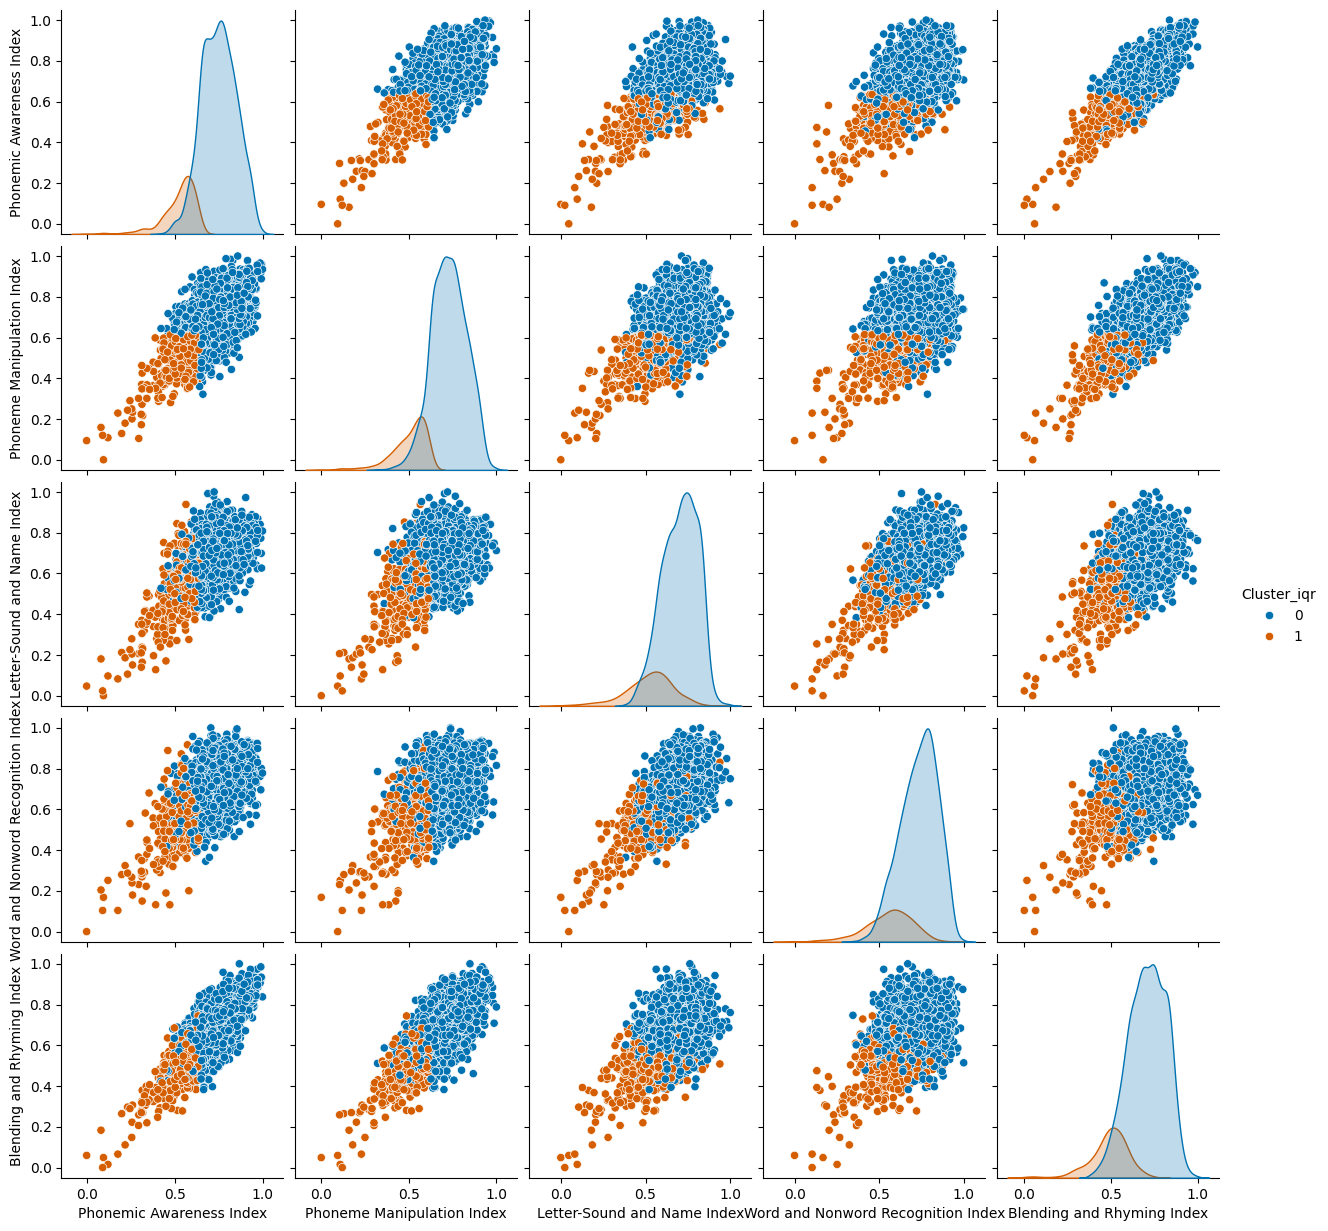

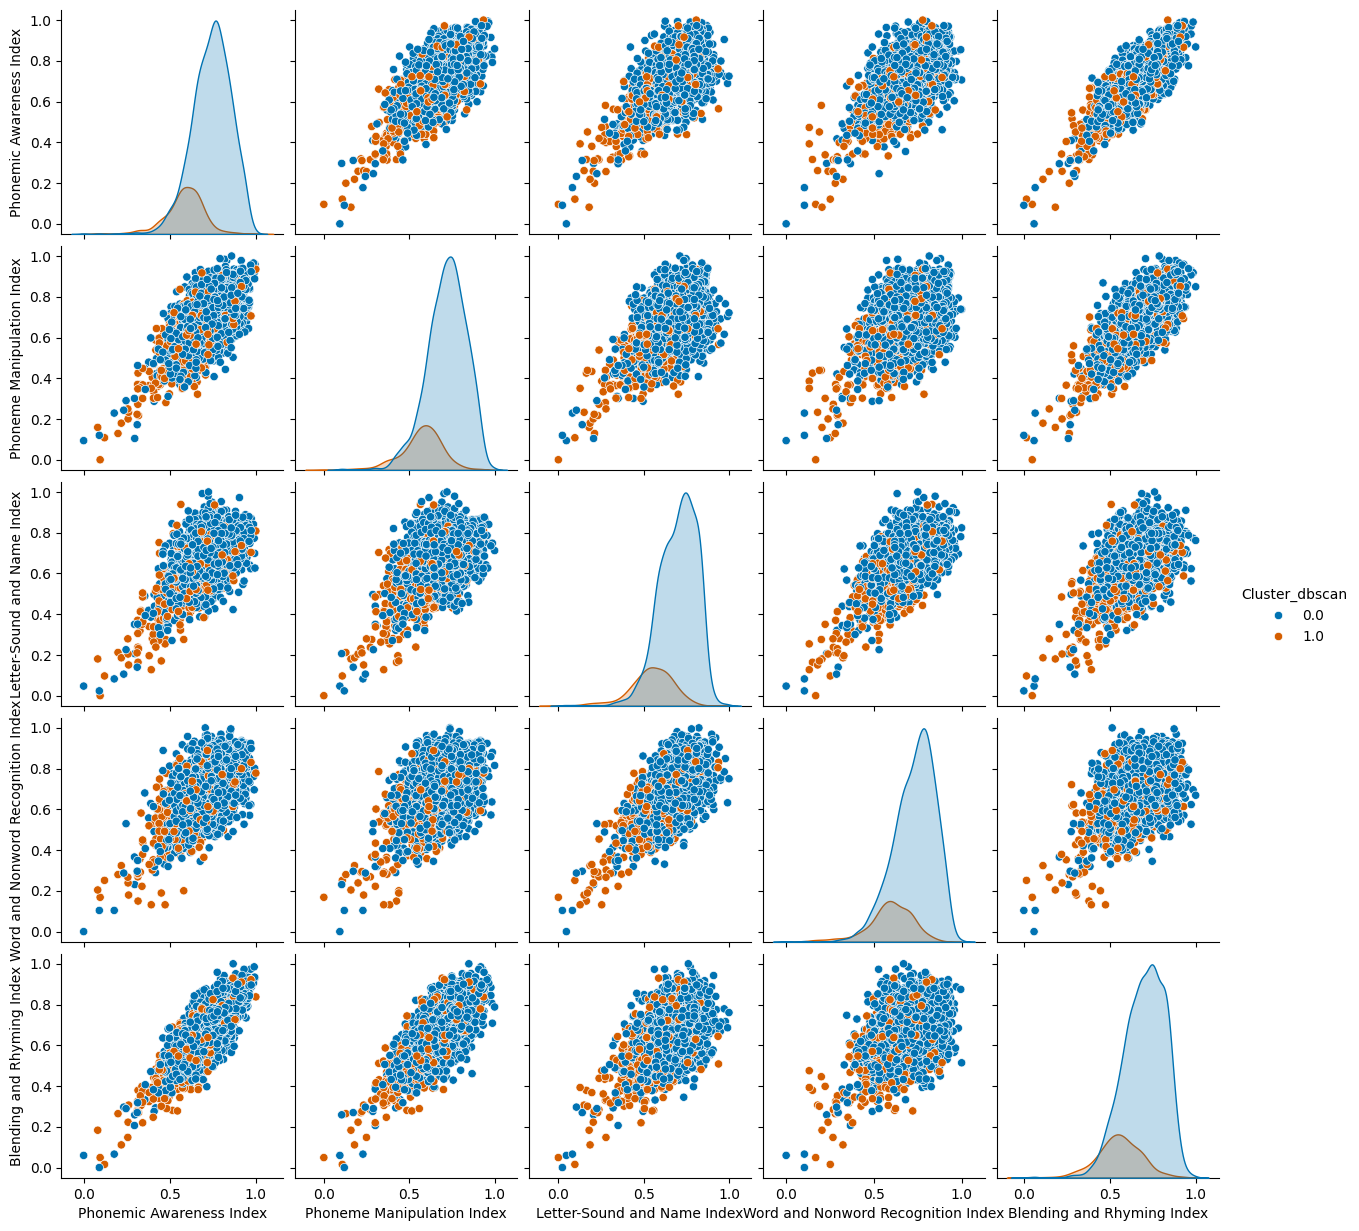

In [56]:
custom_palette = {0: "#0072B2", 1: "#D55E00"}

# Create pairplot of the indices and colour by cluster
sns.pairplot(df_with_labels_indices_relabelled[['Phonemic Awareness Index', 'Phoneme Manipulation Index', 'Letter-Sound and Name Index', 'Word and Nonword Recognition Index', 'Blending and Rhyming Index']], diag_kind='kde')
sns.pairplot(df_with_labels_indices_relabelled[['Phonemic Awareness Index', 'Phoneme Manipulation Index', 'Letter-Sound and Name Index', 'Word and Nonword Recognition Index', 'Blending and Rhyming Index', 'Cluster_iqr']], diag_kind='kde', hue='Cluster_iqr', palette=custom_palette)
plt.savefig('iqr_pairplot.svg')
sns.pairplot(df_with_labels_indices_relabelled[['Phonemic Awareness Index', 'Phoneme Manipulation Index', 'Letter-Sound and Name Index', 'Word and Nonword Recognition Index', 'Blending and Rhyming Index', 'Cluster_dbscan']], diag_kind='kde', hue='Cluster_dbscan', palette=custom_palette)
plt.savefig('dbscan_pairplot.svg')


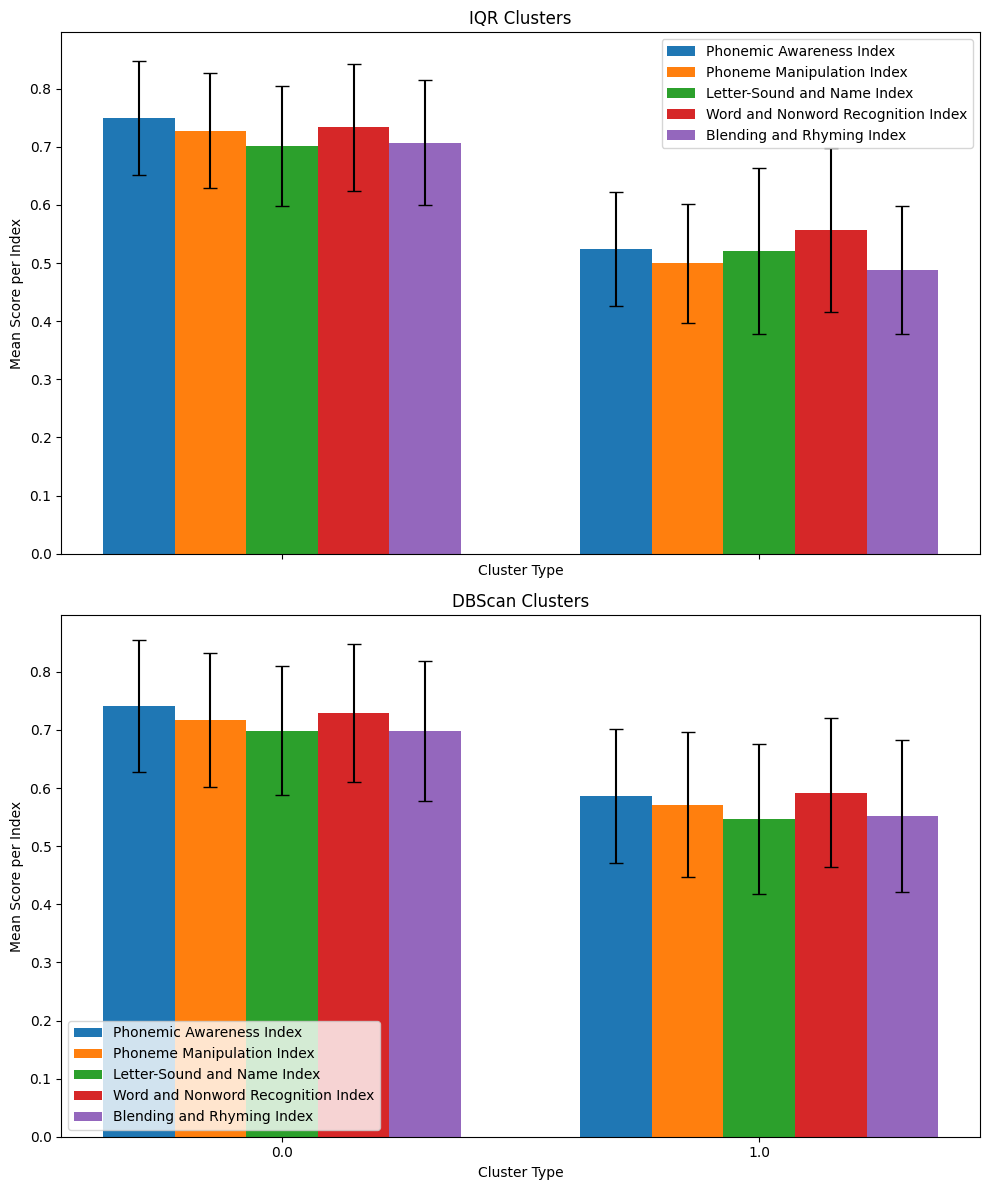

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def create_side_by_side_bar_charts(indices_df, x_label='Cluster', y_label='Mean Score', titles=None):
    """Creates side-by-side bar charts with error bars for mean scores on each index by cluster.

    Args:
        indices_df: A pandas DataFrame containing the index scores and cluster labels.
        x_label: Label for the x-axis.
        y_label: Label for the y-axis.
        titles: List of titles for each subplot.
    """
    cluster_types = ['Cluster_iqr', 'Cluster_dbscan']
    indices = ['Phonemic Awareness Index', 'Phoneme Manipulation Index', 'Letter-Sound and Name Index', 'Word and Nonword Recognition Index', 'Blending and Rhyming Index']

    if titles is None:
        titles = [f'Mean Index Scores by {col} with Error Bars' for col in cluster_types]

    fig, ax = plt.subplots(2, 1, figsize=(10, 12), sharex=True, sharey=True)

    for a, cluster_col, title in zip(ax, cluster_types, titles):
        means = indices_df.groupby(cluster_col).mean()
        stds = indices_df.groupby(cluster_col).std()

        x = np.arange(len(means.index))  # Cluster labels as x-axis
        width = 0.15  # Width of bars to ensure side-by-side placement

        for i, index in enumerate(indices):
            a.bar(x + i * width, means[index], width, label=index, yerr=stds[index], capsize=5)

        a.set_xticks(x + width * (len(indices) - 1) / 2)
        a.set_xticklabels(means.index.astype(str))
        a.set_xlabel(x_label)
        a.set_ylabel(y_label)
        a.set_title(title)
        a.legend()

    plt.tight_layout()
    plt.savefig('mean_indices.svg')
    plt.show()

# Example usage:
create_side_by_side_bar_charts(df_with_labels_indices_relabelled, x_label='Cluster Type', y_label='Mean Score per Index', titles=['IQR Clusters', 'DBScan Clusters'])

In [58]:
# Check for bias to eslstatus
print(df_with_labels_relabelled.loc[df_with_labels_relabelled['Cluster_dbscan'] == 1, 'eslstatus'].value_counts())

print(df_with_labels_relabelled.loc[df_with_labels_relabelled['Cluster_iqr'] == 1, 'eslstatus'].value_counts())

eslstatus
0    427
1     48
Name: count, dtype: int64
eslstatus
0    398
1     45
Name: count, dtype: int64


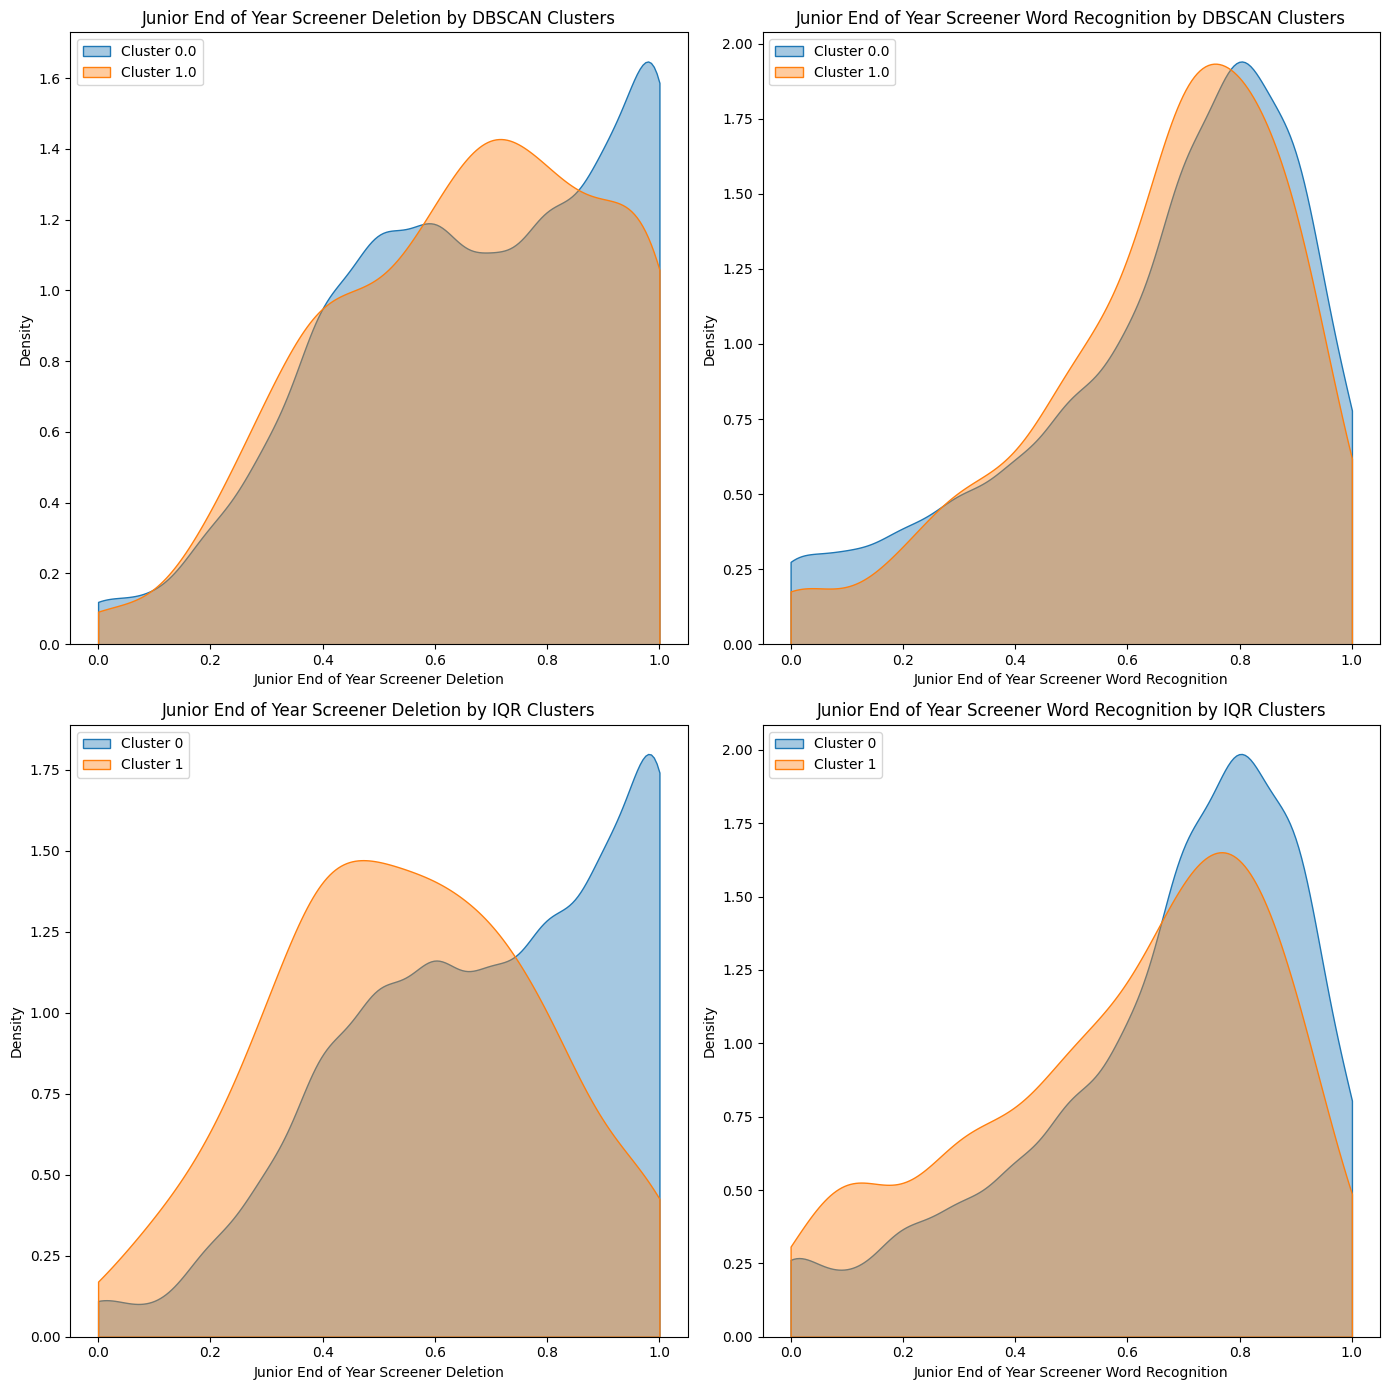

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

def create_2x2_kde_subplots(df, column1, column2, cluster_columns):
    fig, axes = plt.subplots(2, 2, figsize=(14, 14), sharex=False)
    axes = axes.flatten()  # Flatten to easily index with a single loop

    # Clean display names for subplot titles
    cluster_labels = {
        'Cluster_dbscan': 'DBSCAN',
        'Cluster_iqr': 'IQR'
    }

    plot_titles = {
        0: f'{column1} by {cluster_labels[cluster_columns[0]]} Clusters',
        1: f'{column2} by {cluster_labels[cluster_columns[0]]} Clusters',
        2: f'{column1} by {cluster_labels[cluster_columns[1]]} Clusters',
        3: f'{column2} by {cluster_labels[cluster_columns[1]]} Clusters',
    }

    for i, cluster_column in enumerate(cluster_columns):
        for j, column in enumerate([column1, column2]):
            ax_index = i * 2 + j
            ax = axes[ax_index]
            ax.set_title(plot_titles[ax_index])
            ax.set_xlabel(column)
            ax.set_ylabel('Density')

            clusters = df[cluster_column].unique()
            for cluster in clusters:
                cluster_df = df[df[cluster_column] == cluster].dropna(subset=[column])
                sns.kdeplot(
                    data=cluster_df, x=column, label=f'Cluster {cluster}',
                    fill=True, common_norm=False, alpha=0.4, ax=ax, clip=(0, 1)
                )

            ax.legend()

    plt.tight_layout()
    plt.savefig('kde_plot_compare.svg')
    plt.show()

# Usage
create_2x2_kde_subplots(
    df_with_labels_relabelled,
    'Junior End of Year Screener Deletion',
    'Junior End of Year Screener Word Recognition',
    cluster_columns=['Cluster_dbscan', 'Cluster_iqr']
)


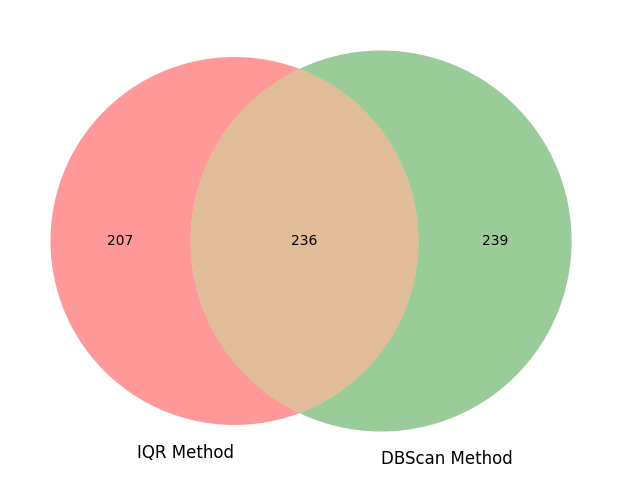

In [60]:
!pip install matplotlib-venn

from matplotlib_venn import venn2

# Get sets of student IDs assigned to Cluster 1 in each dataset
cluster_1_iqr = set(df_with_labels_relabelled[df_with_labels_relabelled["Cluster_iqr"] == 1]["studentid"])
cluster_1_dbscan = set(df_with_labels_relabelled[df_with_labels_relabelled["Cluster_dbscan"] == 1]["studentid"])

# Create the Venn diagram
plt.figure(figsize=(10,6))
venn = venn2([cluster_1_iqr, cluster_1_dbscan],
             set_labels=('IQR Method', 'DBScan Method'))

# Label the subset counts
venn.get_label_by_id('10').set_text(len(cluster_1_iqr - cluster_1_dbscan))  # Only in IQR
venn.get_label_by_id('01').set_text(len(cluster_1_dbscan - cluster_1_iqr))  # Only in dbscan
venn.get_label_by_id('11').set_text(len(cluster_1_iqr & cluster_1_dbscan))  # In both

# Title and show plot
plt.savefig('venn_iqr_dbscan.svg')
plt.show()

In [61]:
df_with_labels_relabelled['Cluster_dbscan'].value_counts()

Cluster_dbscan
0.0    2452
1.0     475
Name: count, dtype: int64

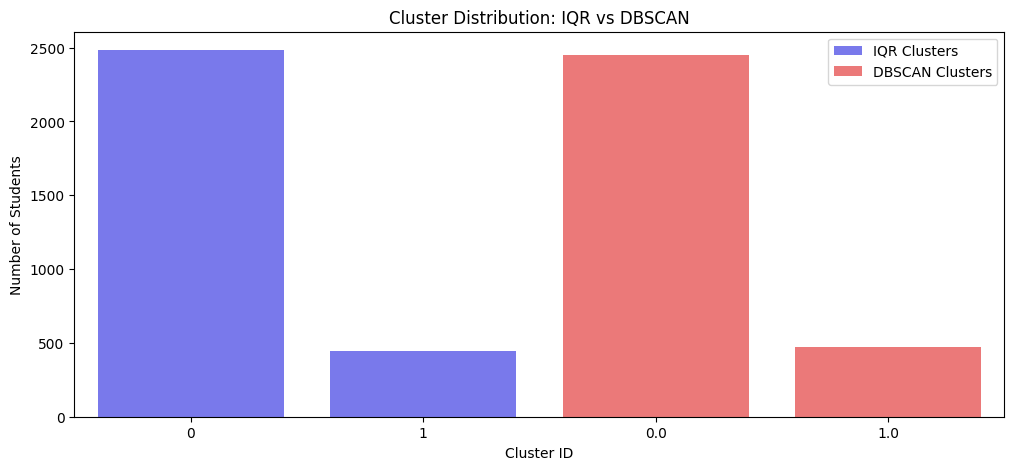

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Create side-by-side count plots
sns.countplot(x="Cluster_iqr", data=df_with_labels_relabelled, color="blue", alpha=0.6, label="IQR Clusters")
sns.countplot(x="Cluster_dbscan", data=df_with_labels_relabelled, color="red", alpha=0.6, label="DBSCAN Clusters")

plt.legend()
plt.title("Cluster Distribution: IQR vs DBSCAN")
plt.xlabel("Cluster ID")
plt.ylabel("Number of Students")
plt.show()


In [63]:
def reorder_columns(df, cluster_cols):
    # Identify column groups
    junior_baseline_cols = [col for col in df.columns if "junior baseline" in col.lower()]
    junior_midpoint_cols = [col for col in df.columns if "junior midpoint" in col.lower()]
    junior_end_of_year_cols = [col for col in df.columns if "junior end of year" in col.lower()]
    senior_baseline_cols = [col for col in df.columns if "senior baseline" in col.lower()]
    progress_rate_cols = [col for col in df.columns if "progress rate" in col.lower()]

    # Identify index-related columns (excluding cluster columns)
    index_cols = [
        "Phonemic Awareness Index", "Phoneme Manipulation Index",
        "Letter-Sound and Name Index", "Word and Nonword Recognition Index",
        "Blending and Rhyming Index"
    ]

    # Exclude cluster and index columns from other groups
    junior_baseline_cols = [col for col in junior_baseline_cols if col not in index_cols + cluster_cols]
    junior_midpoint_cols = [col for col in junior_midpoint_cols if col not in index_cols + cluster_cols]
    junior_end_of_year_cols = [col for col in junior_end_of_year_cols if col not in index_cols + cluster_cols]
    senior_baseline_cols = [col for col in senior_baseline_cols if col not in index_cols + cluster_cols]
    progress_rate_cols = [col for col in progress_rate_cols if col not in index_cols + cluster_cols]

    # Ensure order is correct
    new_order = (
        ["studentid"] +
        junior_baseline_cols + junior_midpoint_cols + junior_end_of_year_cols +
        senior_baseline_cols +
        progress_rate_cols + index_cols + cluster_cols
    )

    # Reorder DataFrame
    df = df[new_order]

    return df

# List of cluster columns
cluster_columns = ["Cluster_iqr", "Cluster_dbscan"]

# Apply reordering
df_reordered = reorder_columns(df_with_labels_relabelled, cluster_columns)

df_reordered.drop_duplicates(inplace=True)

<ipython-input-63-e1443a566a10>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reordered.drop_duplicates(inplace=True)


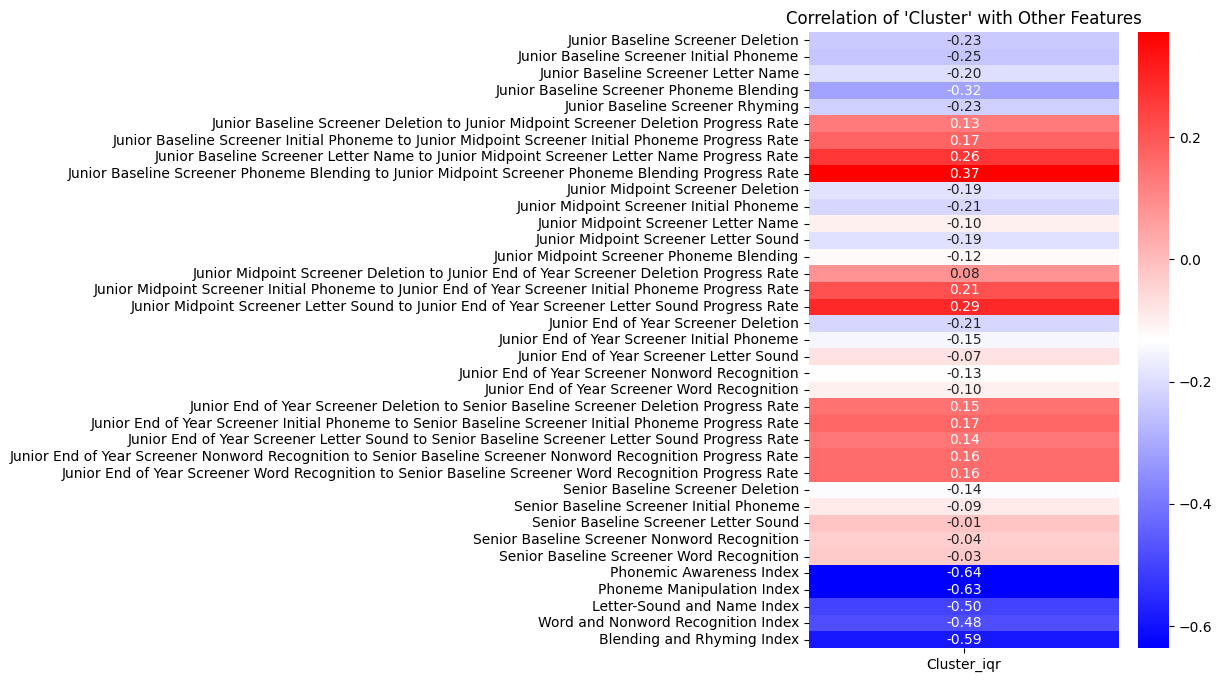

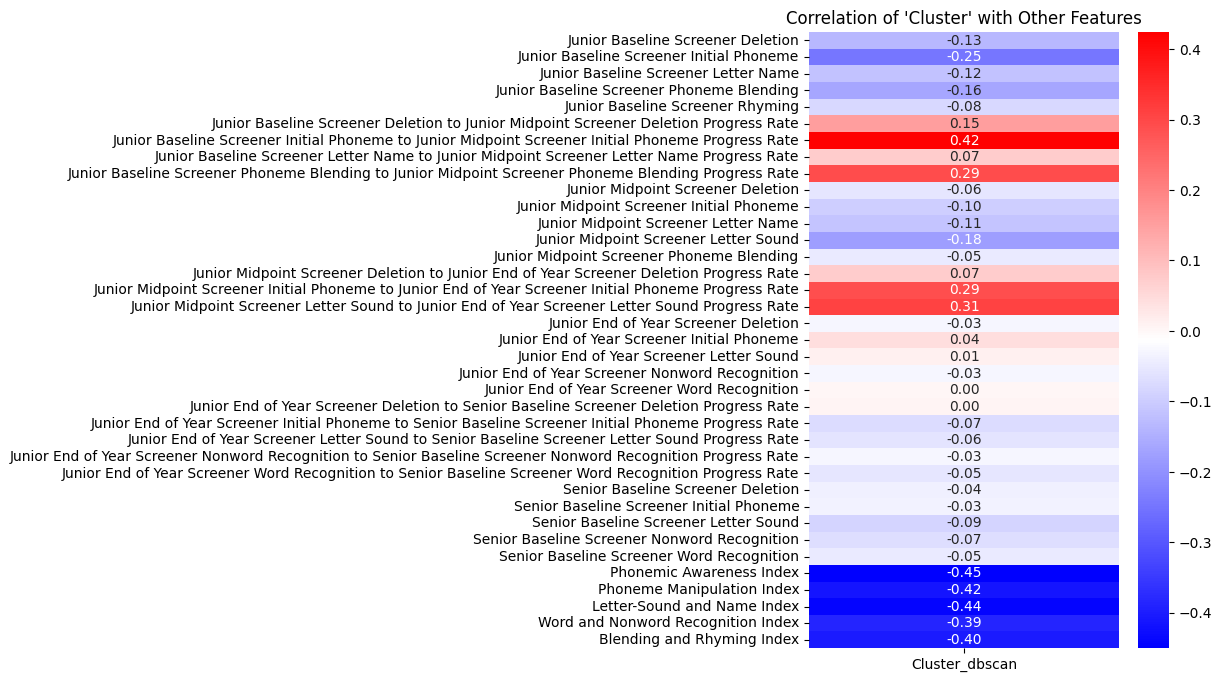

In [64]:
import seaborn as sns


# Compute correlation matrix and select only 'Cluster_iqr'
# Exclude non-numeric columns from the correlation calculation
correlation_matrix = df_reordered.drop(columns=['Cluster_dbscan']).select_dtypes(include='number').corr()[['Cluster_iqr']]

correlation_matrix = correlation_matrix.drop(['Cluster_iqr'], axis=0)
correlation_matrix = correlation_matrix[~correlation_matrix.index.duplicated(keep='first')]

# Plot the heatmap
plt.figure(figsize=(5, 8))  # Adjust figure size for a single-column heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='bwr', fmt=".2f")

plt.title("Correlation of 'Cluster' with Other Features")
plt.show()

# Compute correlation matrix and select only 'Cluster_dbscan'
# Exclude non-numeric columns from the correlation calculation
correlation_matrix = df_reordered.drop(columns=['Cluster_iqr']).select_dtypes(include='number').corr()[['Cluster_dbscan']]

correlation_matrix = correlation_matrix.drop(['Cluster_dbscan'], axis=0)
correlation_matrix = correlation_matrix[~correlation_matrix.index.duplicated(keep='first')]

# Plot the heatmap
plt.figure(figsize=(5, 8))  # Adjust figure size for a single-column heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='bwr', fmt=".2f")

plt.title("Correlation of 'Cluster' with Other Features")
plt.show()

<ipython-input-65-d03b15c2997b>:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, .9, 1])


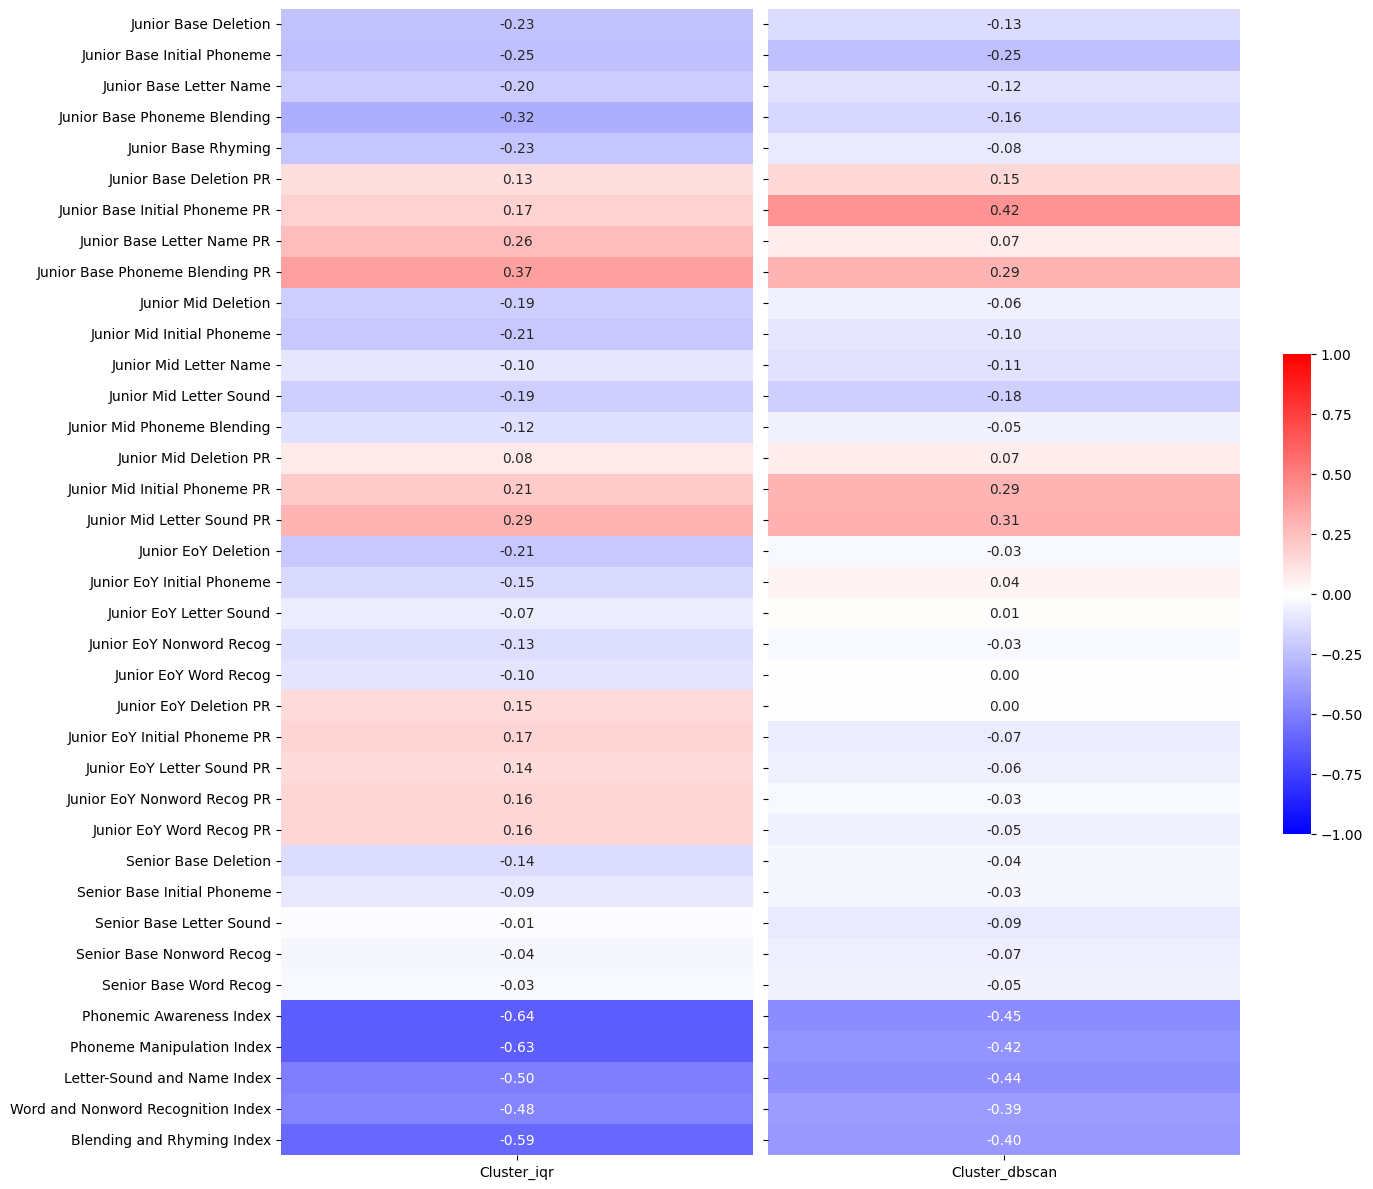

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def create_combined_heatmap(df_reordered):
    cluster_types = ['Cluster_iqr', 'Cluster_dbscan']
    label_mapping = {
        'Junior Baseline Screener Deletion': 'Junior Base Deletion',
        'Junior Baseline Screener Initial Phoneme': 'Junior Base Initial Phoneme',
        'Junior Baseline Screener Letter Name': 'Junior Base Letter Name',
        'Junior Baseline Screener Phoneme Blending': 'Junior Base Phoneme Blending',
        'Junior Baseline Screener Rhyming': 'Junior Base Rhyming',
        'Junior Midpoint Screener Deletion': 'Junior Mid Deletion',
        'Junior Midpoint Screener Initial Phoneme': 'Junior Mid Initial Phoneme',
        'Junior Midpoint Screener Letter Name': 'Junior Mid Letter Name',
        'Junior Midpoint Screener Letter Sound': 'Junior Mid Letter Sound',
        'Junior Midpoint Screener Phoneme Blending': 'Junior Mid Phoneme Blending',
        'Junior End of Year Screener Deletion': 'Junior EoY Deletion',
        'Junior End of Year Screener Initial Phoneme': 'Junior EoY Initial Phoneme',
        'Junior End of Year Screener Letter Sound': 'Junior EoY Letter Sound',
        'Junior End of Year Screener Nonword Recognition': 'Junior EoY Nonword Recog',
        'Junior End of Year Screener Word Recognition': 'Junior EoY Word Recog',
        'Senior Baseline Screener Deletion': 'Senior Base Deletion',
        'Senior Baseline Screener Initial Phoneme': 'Senior Base Initial Phoneme',
        'Senior Baseline Screener Letter Sound': 'Senior Base Letter Sound',
        'Senior Baseline Screener Nonword Recognition': 'Senior Base Nonword Recog',
        'Senior Baseline Screener Word Recognition': 'Senior Base Word Recog',
        'Junior Baseline Screener Initial Phoneme to Junior Midpoint Screener Initial Phoneme Progress Rate': 'Junior Base Initial Phoneme PR',
        'Junior Baseline Screener Letter Name to Junior Midpoint Screener Letter Name Progress Rate': 'Junior Base Letter Name PR',
        'Junior Baseline Screener Phoneme Blending to Junior Midpoint Screener Phoneme Blending Progress Rate': 'Junior Base Phoneme Blending PR',
        'Junior Baseline Screener Deletion to Junior Midpoint Screener Deletion Progress Rate': 'Junior Base Deletion PR',
        'Junior Midpoint Screener Initial Phoneme to Junior End of Year Screener Initial Phoneme Progress Rate': 'Junior Mid Initial Phoneme PR',
        'Junior Midpoint Screener Letter Name to Junior End of Year Screener Letter Name Progress Rate': 'Junior Mid Letter Name PR',
        'Junior Midpoint Screener Phoneme Blending to Junior End of Year Screener Phoneme Blending Progress Rate': 'Junior Mid Phoneme Blending PR',
        'Junior Midpoint Screener Deletion to Junior End of Year Screener Deletion Progress Rate': 'Junior Mid Deletion PR',
        'Junior Midpoint Screener Letter Sound to Junior End of Year Screener Letter Sound Progress Rate': 'Junior Mid Letter Sound PR',
        'Junior Midpoint Screener Nonword Recognition to Junior End of Year Screener Nonword Recognition Progress Rate': 'Junior Mid Nonword Recog PR',
        'Junior Midpoint Screener Word Recognition to Junior End of Year Screener Word Recognition Progress Rate': 'Junior Mid Word Recog PR',
        'Junior End of Year Screener Deletion to Senior Baseline Screener Deletion Progress Rate': 'Junior EoY Deletion PR',
        'Junior End of Year Screener Initial Phoneme to Senior Baseline Screener Initial Phoneme Progress Rate': 'Junior EoY Initial Phoneme PR',
        'Junior End of Year Screener Letter Sound to Senior Baseline Screener Letter Sound Progress Rate': 'Junior EoY Letter Sound PR',
        'Junior End of Year Screener Nonword Recognition to Senior Baseline Screener Nonword Recognition Progress Rate': 'Junior EoY Nonword Recog PR',
        'Junior End of Year Screener Word Recognition to Senior Baseline Screener Word Recognition Progress Rate': 'Junior EoY Word Recog PR'

        }

    df_reordered = df_reordered.rename(columns=label_mapping)

    # Compute correlation matrices
    correlation_matrices = []
    for cluster_col in cluster_types:
        correlation_matrix = df_reordered.drop(columns=[c for c in cluster_types if c != cluster_col])\
                                     .select_dtypes(include='number').corr()[[cluster_col]]
        correlation_matrix = correlation_matrix.drop([cluster_col], axis=0)
        correlation_matrix = correlation_matrix[~correlation_matrix.index.duplicated(keep='first')]
        correlation_matrices.append(correlation_matrix)

    # Find global min and max for normalization
    vmin = min(cm.min().min() for cm in correlation_matrices)
    vmax = max(cm.max().max() for cm in correlation_matrices)

    fig, axes = plt.subplots(1, 2, figsize=(14, 12), sharey=True)
    cbar_ax = fig.add_axes([.92, .3, .02, .4])  # Shared colorbar axis

    for ax, cluster_col, correlation_matrix in zip(axes, cluster_types, correlation_matrices):
        sns.heatmap(correlation_matrix, annot=True, cmap='bwr', fmt=".2f", ax=ax, vmin=-1, vmax=1,
                    cbar_ax=cbar_ax if ax == axes[-1] else None, cbar=ax == axes[-1])

    plt.tight_layout(rect=[0, 0, .9, 1])
    plt.savefig('combined_heatmap_annotated.svg')
    plt.show()

# Example usage:
create_combined_heatmap(df_reordered)


In [66]:
df_with_labels_nonesl = df_with_labels[df_with_labels['eslstatus'] == 0]

In [67]:
df_least_missing_non_esl_scaled, scaler = scale(df_least_missing_non_esl)

In [68]:
df_with_labels_nonesl_relabel = df_with_labels_nonesl.copy()
df_with_labels_nonesl_relabel['Cluster_dbscan'] = df_with_labels_nonesl_relabel['Cluster_dbscan'].replace({-1: 1, 2: 1, 3:0})

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


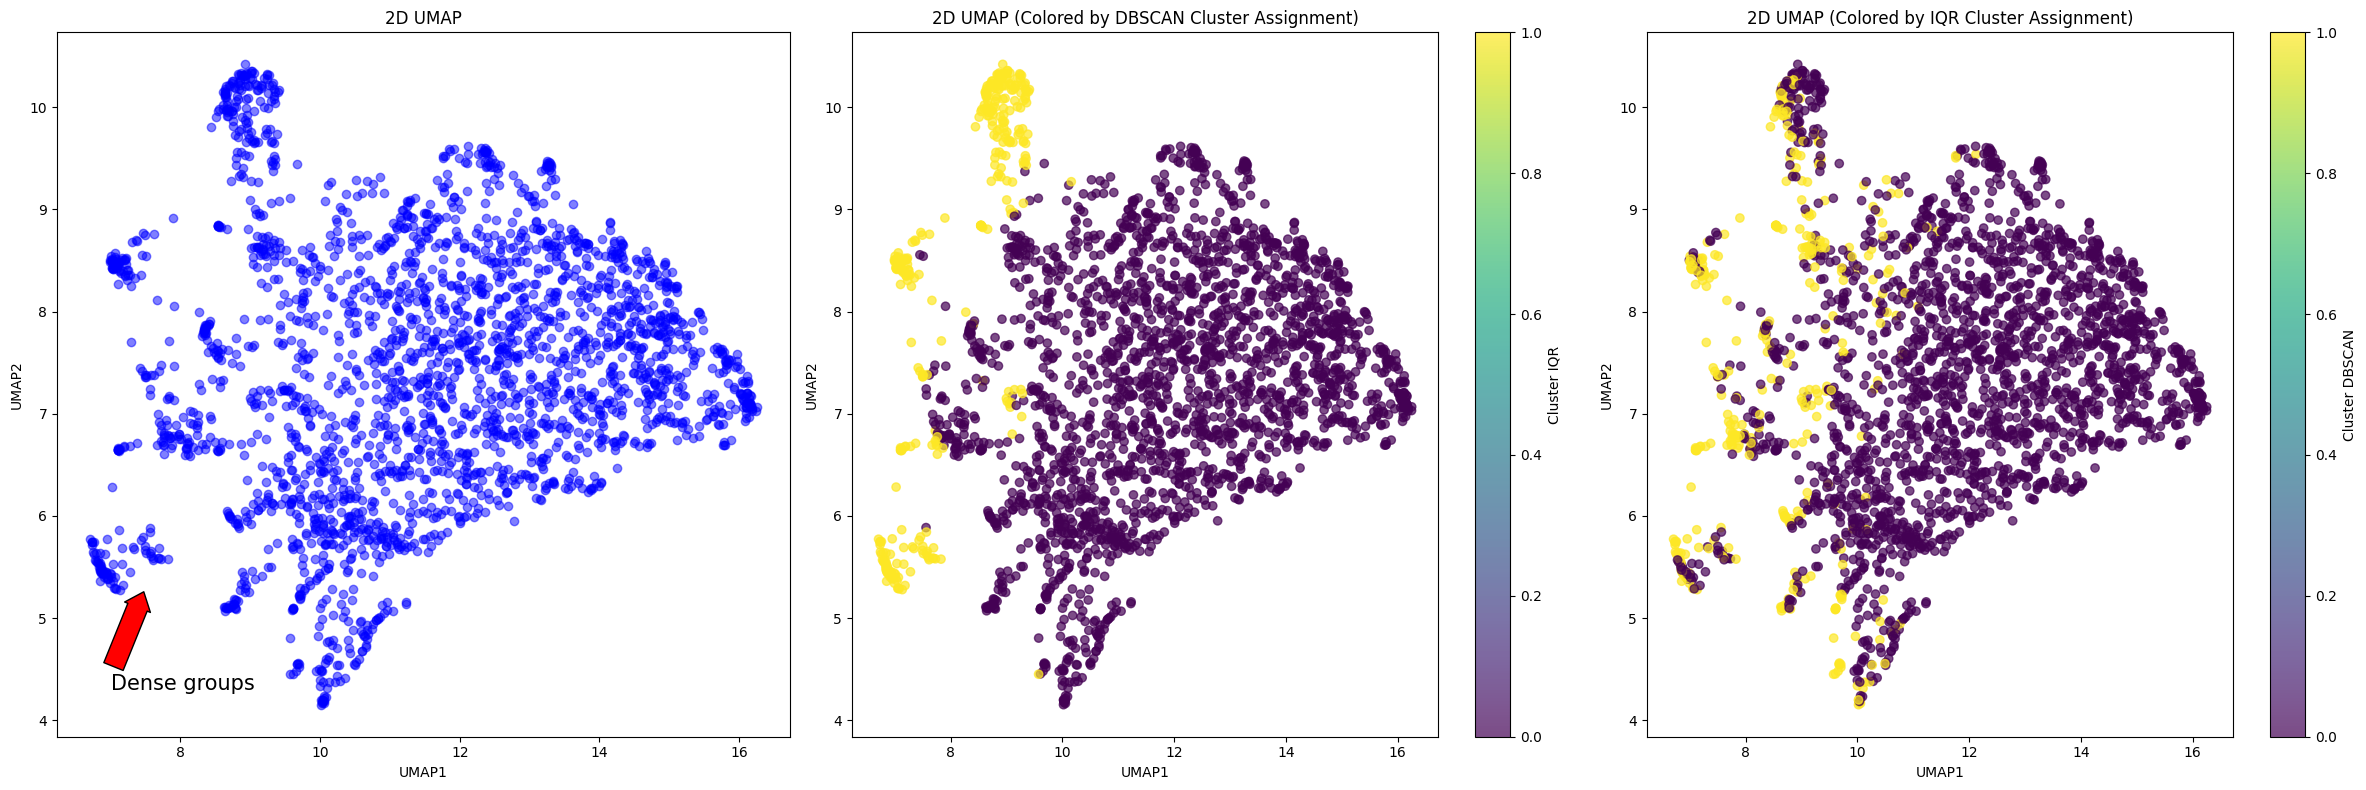

In [69]:
import umap
import matplotlib.pyplot as plt

def custom_umap_plot(df, metric='euclidean', min_dist=0.01, n_neighbors=15):
    fig, axes = plt.subplots(1, 3, figsize=(24, 8))  # Create three subplots side by side

    # UMAP 2D Plot
    reducer_2d = umap.UMAP(n_components=2, random_state=42, metric=metric, min_dist=min_dist, n_neighbors=n_neighbors)

    # Select only numeric columns for UMAP
    numeric_df = df.select_dtypes(include='number')

    # Drop rows with NaN values in the numeric data
    numeric_df_clean = numeric_df.dropna()  # Remove rows with any NaN values

    # Drop cluster and student ID columns from the cleaned numeric data
    X_umap_2d = reducer_2d.fit_transform(df_least_missing_non_esl_scaled, errors='ignore')

    # Left subplot: Plain UMAP scatter plot (no colors)
    axes[0].scatter(X_umap_2d[:, 0], X_umap_2d[:, 1], c='blue', alpha=0.5, marker='o')
    axes[0].set_xlabel('UMAP1')
    axes[0].set_ylabel('UMAP2')
    axes[0].set_title('2D UMAP')

    # Middle subplot: UMAP scatter plot colored by `Cluster_iqr`
    scatter1 = axes[2].scatter(X_umap_2d[:, 0], X_umap_2d[:, 1], c=df_with_labels_nonesl['Cluster_iqr'], cmap='viridis', alpha=0.7, marker='o')
    axes[2].set_xlabel('UMAP1')
    axes[2].set_ylabel('UMAP2')
    axes[2].set_title('2D UMAP (Colored by IQR Cluster Assignment)')

    # Add a colorbar for `Cluster_iqr`
    cbar1 = fig.colorbar(scatter1, ax=axes[1])
    cbar1.set_label("Cluster IQR")

    # Right subplot: UMAP scatter plot colored by `Cluster_dbscan`
    scatter2 = axes[1].scatter(X_umap_2d[:, 0], X_umap_2d[:, 1], c=df_with_labels_nonesl_relabel['Cluster_dbscan'], cmap='viridis', alpha=0.7, marker='o')
    axes[1].set_xlabel('UMAP1')
    axes[1].set_ylabel('UMAP2')
    axes[1].set_title('2D UMAP (Colored by DBSCAN Cluster Assignment)')

    # Add a colorbar for `Cluster_dbscan`
    cbar2 = fig.colorbar(scatter2, ax=axes[2])
    cbar2.set_label("Cluster DBSCAN")

    # Add an arrow to the left side of the figure
    axes[0].annotate('Dense groups', xy=(7.5, 5.3), xytext=(7, 4.3), fontsize=15,
                     arrowprops=dict(facecolor='red', shrink=0.05, width=15, headwidth=20))

    plt.tight_layout()
    plt.savefig('umap_clustered_all.svg')
    plt.show()

    return X_umap_2d

X_umap_2d = custom_umap_plot(df_with_labels_nonesl, metric='euclidean', min_dist=0.01, n_neighbors=15)


In [70]:
df_least_missing_non_esl_scaled, scaler = scale(df_least_missing_non_esl)

In [71]:
test_clustering(df_least_missing_non_esl_scaled, cluster_labels=df_with_labels_nonesl_relabel['Cluster_dbscan'], clusteringname="DBSCAN (Clustered)")

{'Silhouette Score': np.float64(0.22576378414170303),
 'Davies-Bouldin Index': np.float64(2.335817406938264),
 'Calinski-Harabasz Index': np.float64(234.6929035696093)}